_Backtesting.py_ Quick Start User Guide
=======================

This tutorial shows some of the features of *backtesting.py*, a Python framework for [backtesting](https://www.investopedia.com/terms/b/backtesting.asp) trading strategies.

_Backtesting.py_ is a small and lightweight, blazing fast backtesting framework that uses state-of-the-art Python structures and procedures (Python 3.5+, Pandas, NumPy, Bokeh). It has a very small and simple API that is easy to remember and quickly shape towards meaningful results. The library _doesn't_ really support stock picking or trading strategies that rely on arbitrage or multi-asset portfolio rebalancing; instead, it works with an individual tradeable asset at a time and is best suited for optimizing position entrance and exit signal strategies, decisions upon values of technical indicators, and it's also a versatile interactive trade visualization and statistics tool.


## Data

_You bring your own data._ Backtesting ingests _all kinds of 
[OHLC](https://en.wikipedia.org/wiki/Open-high-low-close_chart)
data_ (stocks, forex, futures, crypto, ...) as a
[pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/10min.html)
with columns `'Open'`, `'High'`, `'Low'`, `'Close'` and (optionally) `'Volume'`. Such data is widely obtainable (see: 
[pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/),
[Quandl](https://www.quandl.com/tools/python),
[findatapy](https://github.com/cuemacro/findatapy)).
Besides these, your data frames can have _additional columns_ which are accessible in your strategies in a similar manner.

DataFrame should ideally be indexed with a _datetime index_ (convert it with [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html)), otherwise a simple range index will do.

In [1]:
# Example OHLC daily data for Google Inc.
from backtesting.test import GOOG

GOOG.tail()

Loading BokehJS ...

,Open,High,Low,Close,Volume
2013-02-25,802.3,808.41,790.49,790.77,2303900
2013-02-26,795.0,795.95,784.40,790.13,2202500
2013-02-27,794.8,804.75,791.11,799.78,2026100
2013-02-28,801.1,806.99,801.03,801.20,2265800
2013-03-01,797.8,807.14,796.15,806.19,2175400


## Strategy

Let's create our first strategy to backtest on these Google data, a simple [moving average (MA) cross-over strategy](https://en.wikipedia.org/wiki/Moving_average_crossover).

_Backtesting.py_ doesn't ship its own set of _technical analysis indicators_. Users favoring TA should probably refer to functions from proven indicator libraries, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org),
but for this example, we can define a simple helper moving average function ourselves:

In [2]:
import pandas as pd


def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

A new strategy needs to extend 
[`Strategy`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy)
class and override its two abstract methods:
[`init()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.init) and
[`next()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.next).

Method `init()` is invoked before the strategy is run. Within it, one ideally precomputes in efficient, vectorized manner whatever indicators and signals the strategy depends on.

Method `next()` is then iteratively called by the
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance, once for each data point (data frame row), simulating the incremental availability of each new full candlestick bar.

Note, _backtesting.py_ cannot make decisions / trades _within_ candlesticks — any new orders are executed on the next candle's _open_ (or the current candle's _close_ if
[`trade_on_close=True`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.__init__)).
If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin with more fine-grained (e.g. hourly) data.

In [3]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 30
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In `init()` as well as in `next()`, the data the strategy is simulated on is available as an instance variable
[`self.data`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.data).

In `init()`, we declare and **compute indicators indirectly by wrapping them in 
[`self.I()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.I)**.
The wrapper is passed a function (our `SMA` function) along with any arguments to call it with (our _close_ values and the MA lag). Indicators wrapped in this way will be automatically plotted, and their legend strings will be intelligently inferred.

In `next()`, we simply check if the faster moving average just crossed over the slower one. If it did and upwards, we close the possible short position and go long; if it did and downwards, we close the open long position and go short. Note, we don't adjust order size, so _Backtesting.py_ assumes _maximal possible position_. We use
[`backtesting.lib.crossover()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.crossover)
function instead of writing more obscure and confusing conditions, such as:

In [4]:
%%script echo

    def next(self):
        if (self.sma1[-2] < self.sma2[-2] and
                self.sma1[-1] > self.sma2[-1]):
            self.position.close()
            self.buy()

        elif (self.sma1[-2] > self.sma2[-2] and    # Ugh!
              self.sma1[-1] < self.sma2[-1]):
            self.position.close()
            self.sell()

In `init()`, the whole series of points was available, whereas **in `next()`, the length of `self.data` and all declared indicators is adjusted** on each `next()` call so that `array[-1]` (e.g. `self.data.Close[-1]` or `self.sma1[-1]`) always contains the most recent value, `array[-2]` the previous value, etc. (ordinary Python indexing of ascending-sorted 1D arrays).

**Note**: `self.data` and any indicators wrapped with `self.I` (e.g. `self.sma1`) are NumPy arrays for performance reasons. If you prefer pandas Series or DataFrame objects, use `Strategy.data.<column>.s` or `Strategy.data.df` accessors respectively. You could also construct the series manually, e.g. `pd.Series(self.data.Close, index=self.data.index)`.

We might avoid `self.position.close()` calls if we primed the
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance with `Backtest(..., exclusive_orders=True)`.

## Backtesting

Let's see how our strategy performs on historical Google data. The
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance is initialized with OHLC data and a strategy _class_ (see API reference for additional options), and we begin with 10,000 units of cash and set broker's commission to realistic 0.2%.

In [5]:
from backtesting import Backtest

bt = Backtest(GOOG, SmaCross, cash=10000, commission=.002)
stats = bt.run()
stats

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                     94.1341
Equity Final [$]                      2116.13
Equity Peak [$]                       10995.6
Return [%]                           -78.8387
Buy &amp; Hold Return [%]                 703.458
Max. Drawdown [%]                    -89.0289
Avg. Drawdown [%]                     -14.862
Max. Drawdown Duration     2877 days 00:00:00
Avg. Drawdown Duration      335 days 00:00:00
# Trades                                   69
Win Rate [%]                          69.5652
Best Trade [%]                         21.969
Worst Trade [%]                      -47.5427
Avg. Trade [%]                       -2.18917
Max. Trade Duration         188 days 00:00:00
Avg. Trade Duration          43 days 00:00:00
Profit Factor                        0.741475
Expectancy [%]                        8.50727
SQN                           

[`Backtest.run()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.run)
method returns a pandas Series of simulation results and statistics associated with our strategy. We see that this simple strategy makes almost 600% return in the period of 9 years, with maximum drawdown 33%, and with longest drawdown period spanning almost two years ...

[`Backtest.plot()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot)
method provides the same insights in a more visual form.

In [6]:
bt.plot()

## Optimization

We hard-coded the two lag parameters (`n1` and `n2`) into our strategy above. However, the strategy may work better with 15–30 or some other cross-over. **We declared the parameters as optimizable by making them [class variables](https://docs.python.org/3/tutorial/classes.html#class-and-instance-variables)**.

We optimize the two parameters by calling
[`Backtest.optimize()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize)
method with each parameter a keyword argument pointing to its pool of possible values to test. Parameter `n1` is tested for values in range between 5 and 30 and parameter `n2` for values between 10 and 70, respectively. Some combinations of values of the two parameters are invalid, i.e. `n1` should not be _larger than_ or equal to `n2`. We limit admissible parameter combinations with an _ad hoc_ constraint function, which takes in the parameters and returns `True` (i.e. admissible) whenever `n1` is less than `n2`. Additionally, we search for such parameter combination that maximizes return over the observed period. We could instead choose to optimize any other key from the returned `stats` series.

In [7]:
%%time

results = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)


CPU times: user 18.6 s, sys: 3.32 ms, total: 18.6 s
Wall time: 18.6 s


In [8]:
results



best_fitness                                                -69897.1
best_parameters                                             [13, 32]
full_results       {&#39;x&#39;: [13, 32], &#39;fun&#39;: -69897.11184, &#39;func_val...
stats_best         Start                     2004-08-19 00:00:00
...
dtype: object

We can look into `stats['_strategy']` to access the Strategy _instance_ and its optimal parameter values (10 and 15).

In [9]:
stats = results.stats_best
stats._strategy

&lt;Strategy SmaCross(n1=13,n2=32)&gt;

In [10]:
bt.plot(plot_volume=False, plot_pl=False)

Strategy optimization managed to up its initial performance _on in-sample data_ by almost 50% and even beat simple
[buy & hold](https://en.wikipedia.org/wiki/Buy_and_hold).
In real life optimization, however, do **take steps to avoid
[overfitting](https://en.wikipedia.org/wiki/Overfitting)**.

## Trade data

In addition to backtest statistics returned by
[`Backtest.run()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.run)
shown above, you can look into _individual trade returns_ and the changing _equity curve_ and _drawdown_ by inspecting the last few, internal keys in the result series.

In [11]:
stats.tail()

Sortino Ratio                                             0.743704
Calmar Ratio                                             0.0786836
_strategy                                    SmaCross(n1=13,n2=32)
_equity_curve                     Equity  DrawdownPct DrawdownD...
_trades              Size  EntryBar  ExitBar  EntryPrice  ExitP...
dtype: object

The columns should be self-explanatory.

In [12]:
stats['_equity_curve']  # Contains equity/drawdown curves. DrawdownDuration is only defined at ends of DD periods.

,Equity,DrawdownPct,DrawdownDuration
2004-08-19,10000.00000,0.000000,NaT
2004-08-20,10000.00000,0.000000,NaT
2004-08-23,10000.00000,0.000000,NaT
2004-08-24,10000.00000,0.000000,NaT
2004-08-25,10000.00000,0.000000,NaT
...,...,...,...
2013-02-25,68570.99184,0.037608,NaT
2013-02-26,68515.95184,0.038381,NaT
2013-02-27,69345.85184,0.026733,NaT
2013-02-28,69467.97184,0.025019,NaT


In [13]:
stats['_trades']  # Contains individual trade data

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-55,74,85,179.59010,182.00,-132.54450,-0.013419,2004-12-03,2004-12-20,17 days
1,54,85,118,182.36400,205.26,1236.38400,0.125551,2004-12-20,2005-02-07,49 days
2,-54,118,122,204.84948,186.66,982.23192,0.088794,2005-02-07,2005-02-11,4 days
3,64,122,131,187.03332,189.15,135.46752,0.011317,2005-02-11,2005-02-25,14 days
4,-64,131,161,188.77170,193.09,-276.37120,-0.022876,2005-02-25,2005-04-11,45 days
...,...,...,...,...,...,...,...,...,...,...
58,-77,1932,1959,603.04150,588.16,1145.87550,0.024677,2012-04-20,2012-05-30,40 days
59,81,1959,1960,589.33632,588.72,-49.92192,-0.001046,2012-05-30,2012-05-31,1 days
60,-81,1960,1989,587.54256,567.12,1654.22736,0.034759,2012-05-31,2012-07-12,42 days
61,87,1989,2062,568.25424,686.80,10313.48112,0.208614,2012-07-12,2012-10-24,104 days


Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).

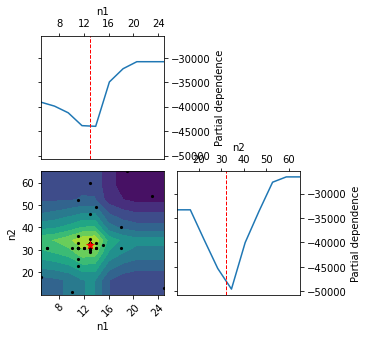

In [14]:
from skopt.plots import plot_objective
_ = plot_objective(results['full_results'], n_points=10)
